## ハンズオンUMAP
UMAPという新しい可視化の手法が開発された。https://github.com/lmcinnes/umap


私的に、この手法の利点は大きく2つあると考えている。
1. t-SNEよりも高速でありながらt-SNEと同じような可視化の結果が得られる。
2. t-SNEと違って、学習済みの空間に、あとから新規のサンプルを布置できる。

特に、2番目について言及している。ブログ記事は日本語では見つからなかった。ので、2番目の強みの紹介がこのブログの目的である。

他にもパラメーターについてまとめている記事やhttps://qiita.com/calderarie/items/ef745ed2a911f356fc8e

UMAPのgithubのREADMEの翻訳をしている記事が見つかったのでぜひ。https://githubja.com/lmcinnes/umap

### なぜ、あとからサンプルを布置できると嬉しいのか？
機械学習のタスクに使えるからである。次元削減したら、その削減された空間(潜在空間)での座標を機械学習アルゴリズムの入力したいと考えるだろう。しかし、t-SNEでは潜在空間にあとからサンプルを布置することができなかった。そのためt-SNEは可視化に使うしかなかったのである。

ところが、UMAPはあとから新規のサンプルを布置できる。このためUMAPは強力な可視化手法でありながら、強力な前処理の手法ともなり得る。

ここからドキュメントの例に従って、(コメントを付け足しつつ)、機械学習にUMAPを使えることを確認する。具体的には、手書き数字の識別タスクを行う。

### まずはドキュメントにそって
ほぼコピペ
https://umap-learn.readthedocs.io/en/latest/transform.html

#### インストール
umapと打たないように注意
```
pip install umap-learn
```

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='white', rc={'figure.figsize':(14,10)})
digits = load_digits()

#### データの概要

In [2]:
#データの詳細を見てみる
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

データ説明から一部抜粋
```
Data Set Characteristics:
    :サンプル数: 5620(と書いてあるものの、説明と異なって実際は1797枚しかありません)
    :説明変数の数: 64
    :何を説明変数としているか: 8x8 の画像のそれぞれのピクセルである。0~16の整数が格納されている。
    :欠損値: なし
```

ラベル： 2


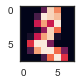

ラベル： 0


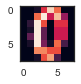

ラベル： 1


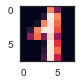

In [3]:
# 適当にいくつか見てみる
for i in [2, 10, 42]:
    print("ラベル：",digits.target[i])
    plt.figure(figsize=(1,1))
    plt.imshow(digits.data[i].reshape(8,8))
    plt.show()

MNISTの軽量版と言ったところか。UMAPで次元削減を行う前に訓練データとテストデータに分けておこう。
#### 訓練とテストに分割

In [4]:
X_train, X_test, y_train, y_test = train_test_split(digits.data,
                                                    digits.target,
                                                    stratify=digits.target,
                                                    random_state=42)
print("訓練データの数",len(y_train),"\tテストデータの数",len(y_test))

訓練データの数 1347 	テストデータの数 450


UMAPでは、1347の訓練データを用いて学習した潜在空間に、テストデータを新たに布置することができる。これが意味することは、t-SNEと異なり、判別器などの前処理に使えるということである。
#### 訓練データで空間を学習

In [5]:
import umap

/Users/masaki/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


CPU times: user 7.11 s, sys: 225 ms, total: 7.33 s
Wall time: 7.32 s


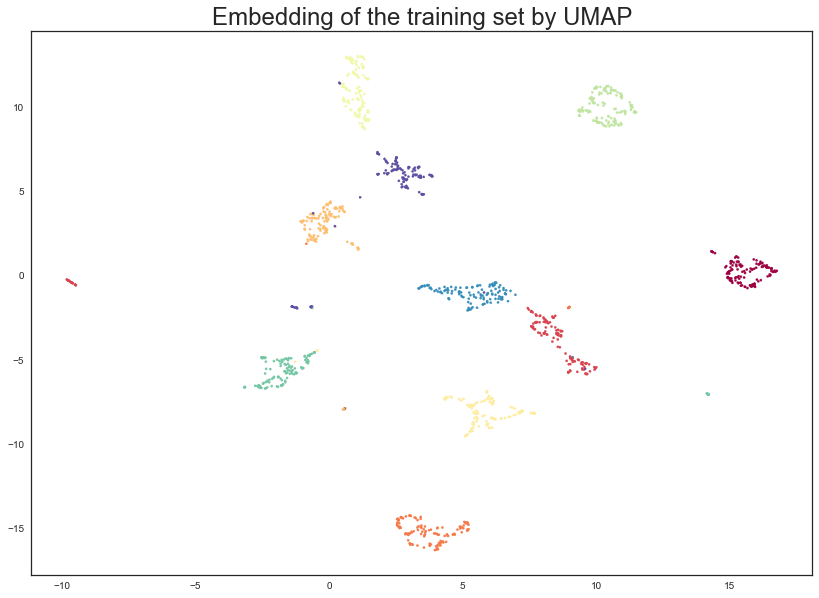

In [6]:
# sklearnと同じようなインターフェイス
#n_neighborsを変えると結果が結構変わる
#処理時間を測るために%timeをしている
%time trans = umap.UMAP(n_neighbors=5,n_components=2, random_state=42).fit(X_train)


plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24)
plt.show()

#### この潜在空間で学習

In [7]:
#SVMでの学習
svc = SVC().fit(trans.embedding_, y_train)
#k-近傍法での学習
knn = KNeighborsClassifier().fit(trans.embedding_, y_train)

さて、二種類のClassifierで潜在空間に布置された訓練データが学習できた。未知のテストデータを判定するためには、テストデータもこの訓練データの潜在空間に落とし込む必要がある。

#### テストデータの潜在空間への布置

In [8]:
#処理時間を測るために%timeをしている
#やはりsklearnと同様にtransformで、データを加工する
%time test_embedding = trans.transform(X_test)

CPU times: user 4.08 s, sys: 102 ms, total: 4.18 s
Wall time: 4.2 s


PCAやLPPみたいな線形の変換とは異なってやはり少し時間がかかる印象。テストデータが潜在空間のどこに布置されたのか実際に確かめてみよう。

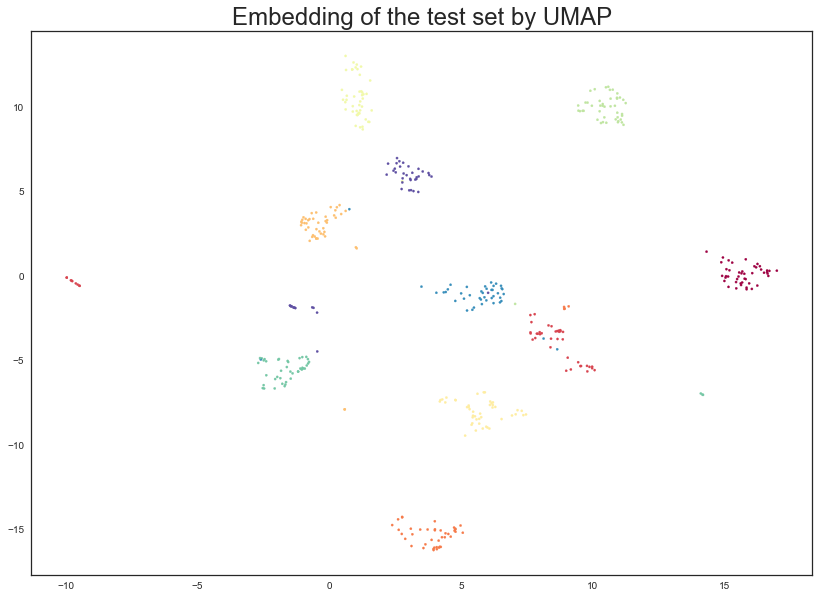

In [9]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=y_test, cmap='Spectral')
plt.title('Embedding of the test set by UMAP', fontsize=24)
plt.show()

色の配置が訓練データと同じことが確認できる。こんなにきれいだとむしろ感動する。

#### テストデータへの汎化性能
では、どれほどテストデータに対して、うまく判別できるのか。正解率を見てみる。

In [10]:
print(
    "SVM:", svc.score(test_embedding, y_test), 
    "\nk-近傍",knn.score(test_embedding, y_test))

SVM: 0.9822222222222222 
k-近傍 0.9822222222222222


パラメーターチューニングもせずにこれほどの正解率がでるとはおそろしい(もっともグリッドサーチしてもほとんど変わらないと思うが)。

### まとめ
* UMAPは可視化だけではなくて、機械学習につかえる！！！！使え！！！
* 潜在空間と元の特徴量空間の対応というか、解釈性がほしいと思った。
* (じつは何も前処理を行わない場合のkNNに負けてる。)

In [11]:
svc = SVC().fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)
print(
    "SVM:", svc.score(X_test, y_test), 
    "\nk-近傍:",knn.score(X_test, y_test))

SVM: 0.62 
k-近傍: 0.9844444444444445
